# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/02c_dim_reduction'

# Loading data

In [4]:
path_to_ftir_data= './../data/preprocessed_data/scaled_data'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-spectra

In [5]:
files = os.listdir(path_to_ftir_data)

In [6]:
data_ranges = {}

for file in files:
    startswith_ftir_flg = file.startswith("ftir")

    if not startswith_ftir_flg:
        continue
    
    high_boundary = int(file.split('_')[-2])
    low_boundary = int(file.split('_')[-1].split('.')[0])

    wn_range = (high_boundary, low_boundary)
    tmp_data = pd.read_csv(f'{path_to_ftir_data}/{file}', sep=';', index_col=0)
    tmp_data.columns = tmp_data.columns.astype(float)

    data_ranges[wn_range] = tmp_data

    print(
        f'-' * 224,
        f'WAVENUMBER RANGE: {wn_range}',
        f'(*) data set shape: {data_ranges[wn_range].shape}',
        f'(*) Wavenumber for data (max/min): {round(data_ranges[wn_range].columns.max()), round(data_ranges[wn_range].columns.min())}',
        sep='\n'
    )

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1800, 1500)
(*) data set shape: (74, 311)
(*) Wavenumber for data (max/min): (1800, 1501)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1500, 1300)
(*) data set shape: (74, 207)
(*) Wavenumber for data (max/min): (1500, 1301)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (3800, 2500)
(*) data set shape: (74, 1348)
(*) Wavenumber for data (max/min): (3800, 250

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(74, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Analysis of lower-dimensional data

## Class for dimensionality reduction

In [15]:
class DimensionalityReduction:
    def __init__(self, data, hue=None):
        self.data = data
        self.hue = hue
        self.results = {}

    def _apply_method(self, method, name, target=None, model_args=None):
        model_args = model_args or {}
        valid = inspect.signature(method).parameters
        model_args = {k: v for k, v in model_args.items() if k in valid}

        model = method(**model_args)

        transformed = (
            model.fit_transform(self.data, target)
            if target is not None
            else model.fit_transform(self.data)
        )

        cols = [f"ax_{i}" for i in range(1, transformed.shape[1] + 1)]
        self.results[name] = pd.DataFrame(transformed, columns=cols)

        if hasattr(model, "explained_variance_ratio_"):
            self.results[f"{name}_variance"] = [
                round(v, 4) for v in model.explained_variance_ratio_
            ]

    def get_pca(self, n_components=2, random_state=42):
        self._apply_method(
            PCA,
            "pca",
            model_args=dict(n_components=n_components, random_state=random_state),
        )

    def get_lda(self, target, n_components=2):
        self._apply_method(
            LinearDiscriminantAnalysis,
            "lda",
            target=target,
            model_args=dict(n_components=n_components, solver="svd"),
        )

    def get_nmf(self, n_components=2, random_state=42):
        self._apply_method(
            NMF,
            "nmf",
            model_args=dict(
                n_components=n_components,
                init="nndsvd",
                max_iter=100_000,
                random_state=random_state,
            ),
        )

    def get_tsne(
        self,
        n_components=2,
        learning_rate=10,
        init="pca",
        perplexity=5,
        n_iter=1_000,
        random_state=42,
    ):
        iter_kw = (
            "n_iter"
            if "n_iter" in inspect.signature(TSNE).parameters
            else "max_iter"
        )

        tsne_args = dict(
            n_components=n_components,
            learning_rate=learning_rate,
            init=init,
            perplexity=perplexity,
            random_state=random_state,
            **{iter_kw: n_iter},
        )

        self._apply_method(TSNE, "tsne", model_args=tsne_args)

    def get_visualization(
        self,
        method="pca",
        ax=None,
        figsize=(8, 6),
        palette="Dark2",
        markersize=14,
        fontstyle="normal",
        fontsize=14,
        path_to_save=None,
        dpi=300,
        title=True,
    ):
        if method not in self.results:
            raise ValueError(f"Method {method} has not been applied. Call get_{method}() first.")

        data = self.results[method]
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.scatterplot(
            data=data,
            x=data.columns[0],
            y=data.columns[1],
            hue=self.hue,
            palette=palette,
            s=markersize,
            ax=ax,
        )

        if method == "pca" and "pca_variance" in self.results:
            var1, var2 = self.results["pca_variance"][:2]
            xlabel = f"Principal Component 1\n($PoEV$ = {var1})"
            ylabel = f"Principal Component 2\n($PoEV$ = {var2})"
        else:
            xlabel, ylabel = "Axis 1", "Axis 2"

        ax.set_xlabel(xlabel, fontstyle=fontstyle, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontstyle=fontstyle, fontsize=fontsize)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=fontsize)

        if title:
            titles = {
                "pca": r"$\mathbf{(A)}$ Principal Component Analysis (PCA)",
                "lda": r"$\mathbf{(B)}$ Linear Discriminant Analysis (LDA)",
                "nmf": r"$\mathbf{(C)}$ Non-negative Matrix Factorization (NMF)",
                "tsne": r"$\mathbf{(D)}$ t-distributed stochastic neighbor embedding ($t$-SNE)",
            }
            ax.set_title(titles.get(method, method.upper()),
                         fontstyle="normal", fontsize=fontsize, fontweight="bold")

        ax.legend(loc="best", fontsize=fontsize - 2, markerscale=0.7)

        if ax is None:
            plt.tight_layout()
            if path_to_save:
                plt.savefig(path_to_save, dpi=600)
            plt.show()

    def get_combined_visualization(
        self,
        figsize=(16, 12),
        palette="Dark2",
        markersize=14,
        fontstyle="normal",
        fontsize=14,
        path_to_save=None,
        dpi=300,
    ):
        methods = ["pca", "lda", "nmf", "tsne"]
        fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
        axes = axes.flatten()

        sns.set_theme()

        for ax, method in zip(axes, methods):
            if method not in self.results:
                raise ValueError(f"Method {method} has not been applied. Call get_{method}() first.")
            self.get_visualization(
                method=method,
                ax=ax,
                palette=palette,
                markersize=markersize,
                fontsize=fontsize,
                title=True,
            )

        plt.tight_layout()
        if path_to_save:
            plt.savefig(path_to_save, dpi=600)
        plt.show()


## Setting parameters for visualization

In [16]:
wn_ranges = sorted(data_ranges.keys(), key=lambda x: (x[0], -x[1]), reverse=True)

for wn_range in wn_ranges:
    print(f'(*) {wn_range}')

(*) (3800, 2500)
(*) (1900, 800)
(*) (1800, 1500)
(*) (1500, 1300)
(*) (1300, 900)


In [17]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class'].tolist()

In [18]:
type_color_dict = {
    r'$d \leq 2$': '#2166AC',
    r'$2 < d \leq 5$': '#67A9CF',
    r'$d > 5$': '#B2182B'
}

figsize = (17, 11.6)
markersize = 700 # 1024

fontsize = 20

## Results visualization

In [19]:
sns.set_theme()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (3800, 2500)


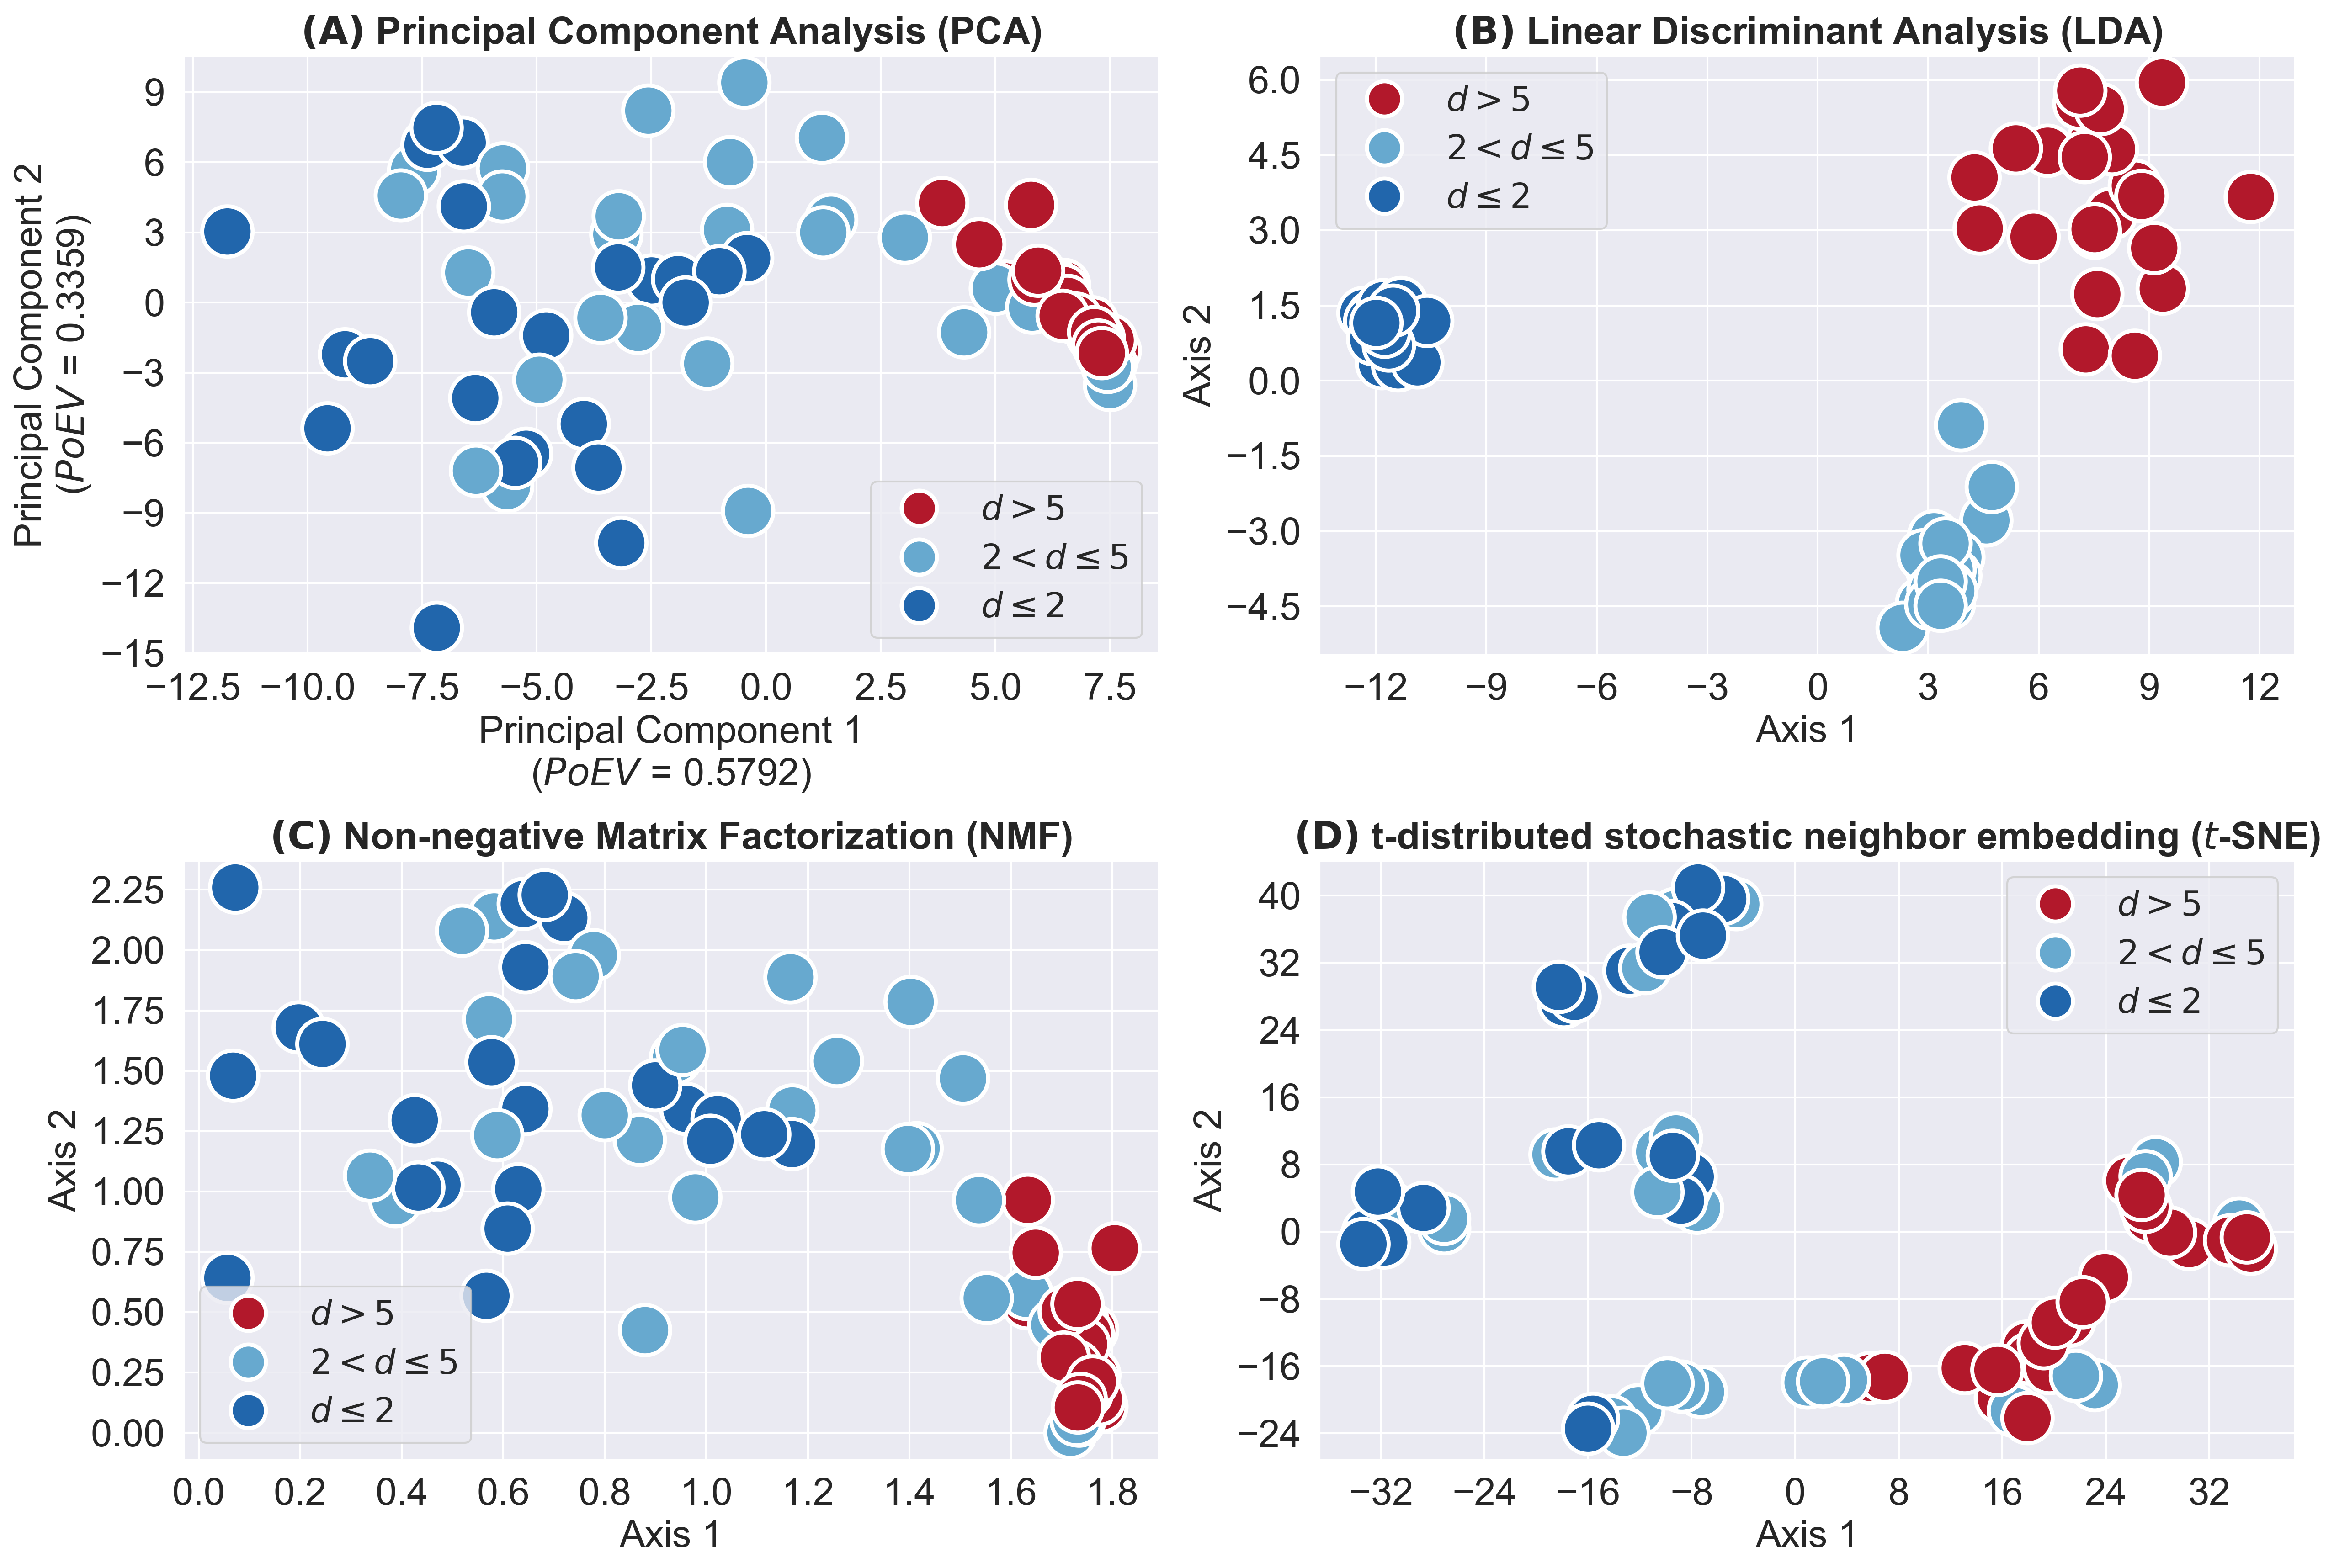

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1900, 800)


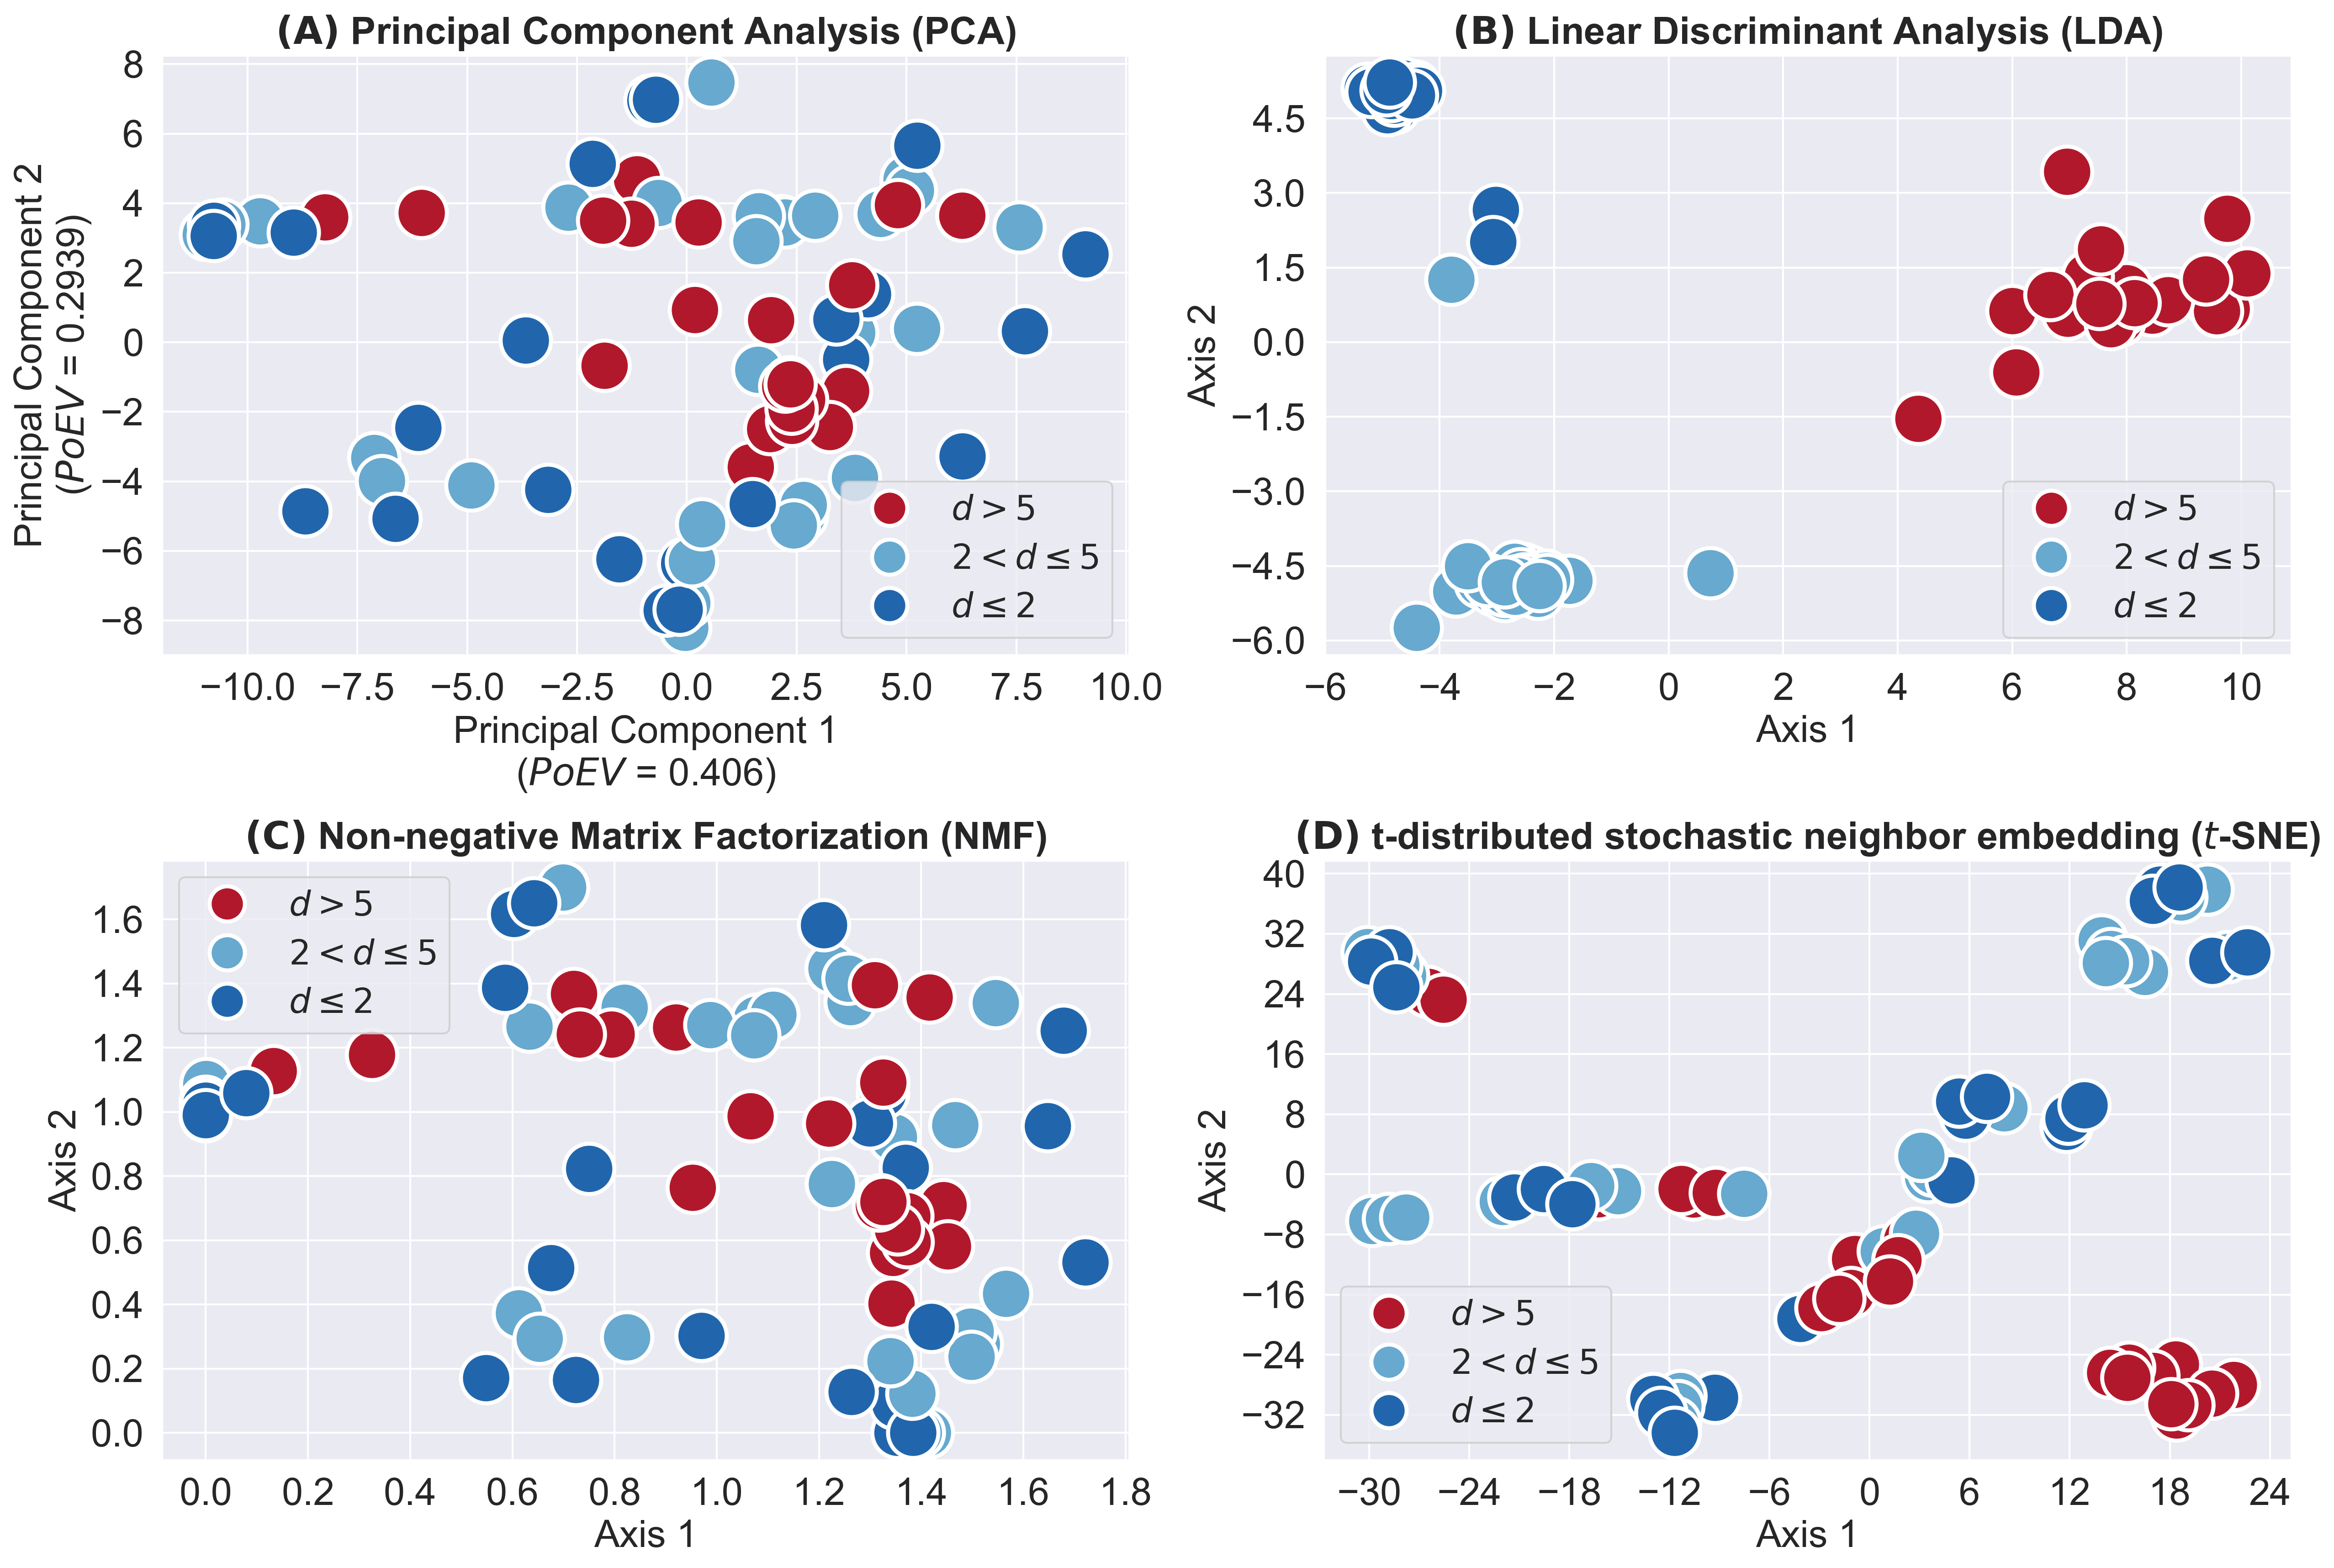

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1800, 1500)


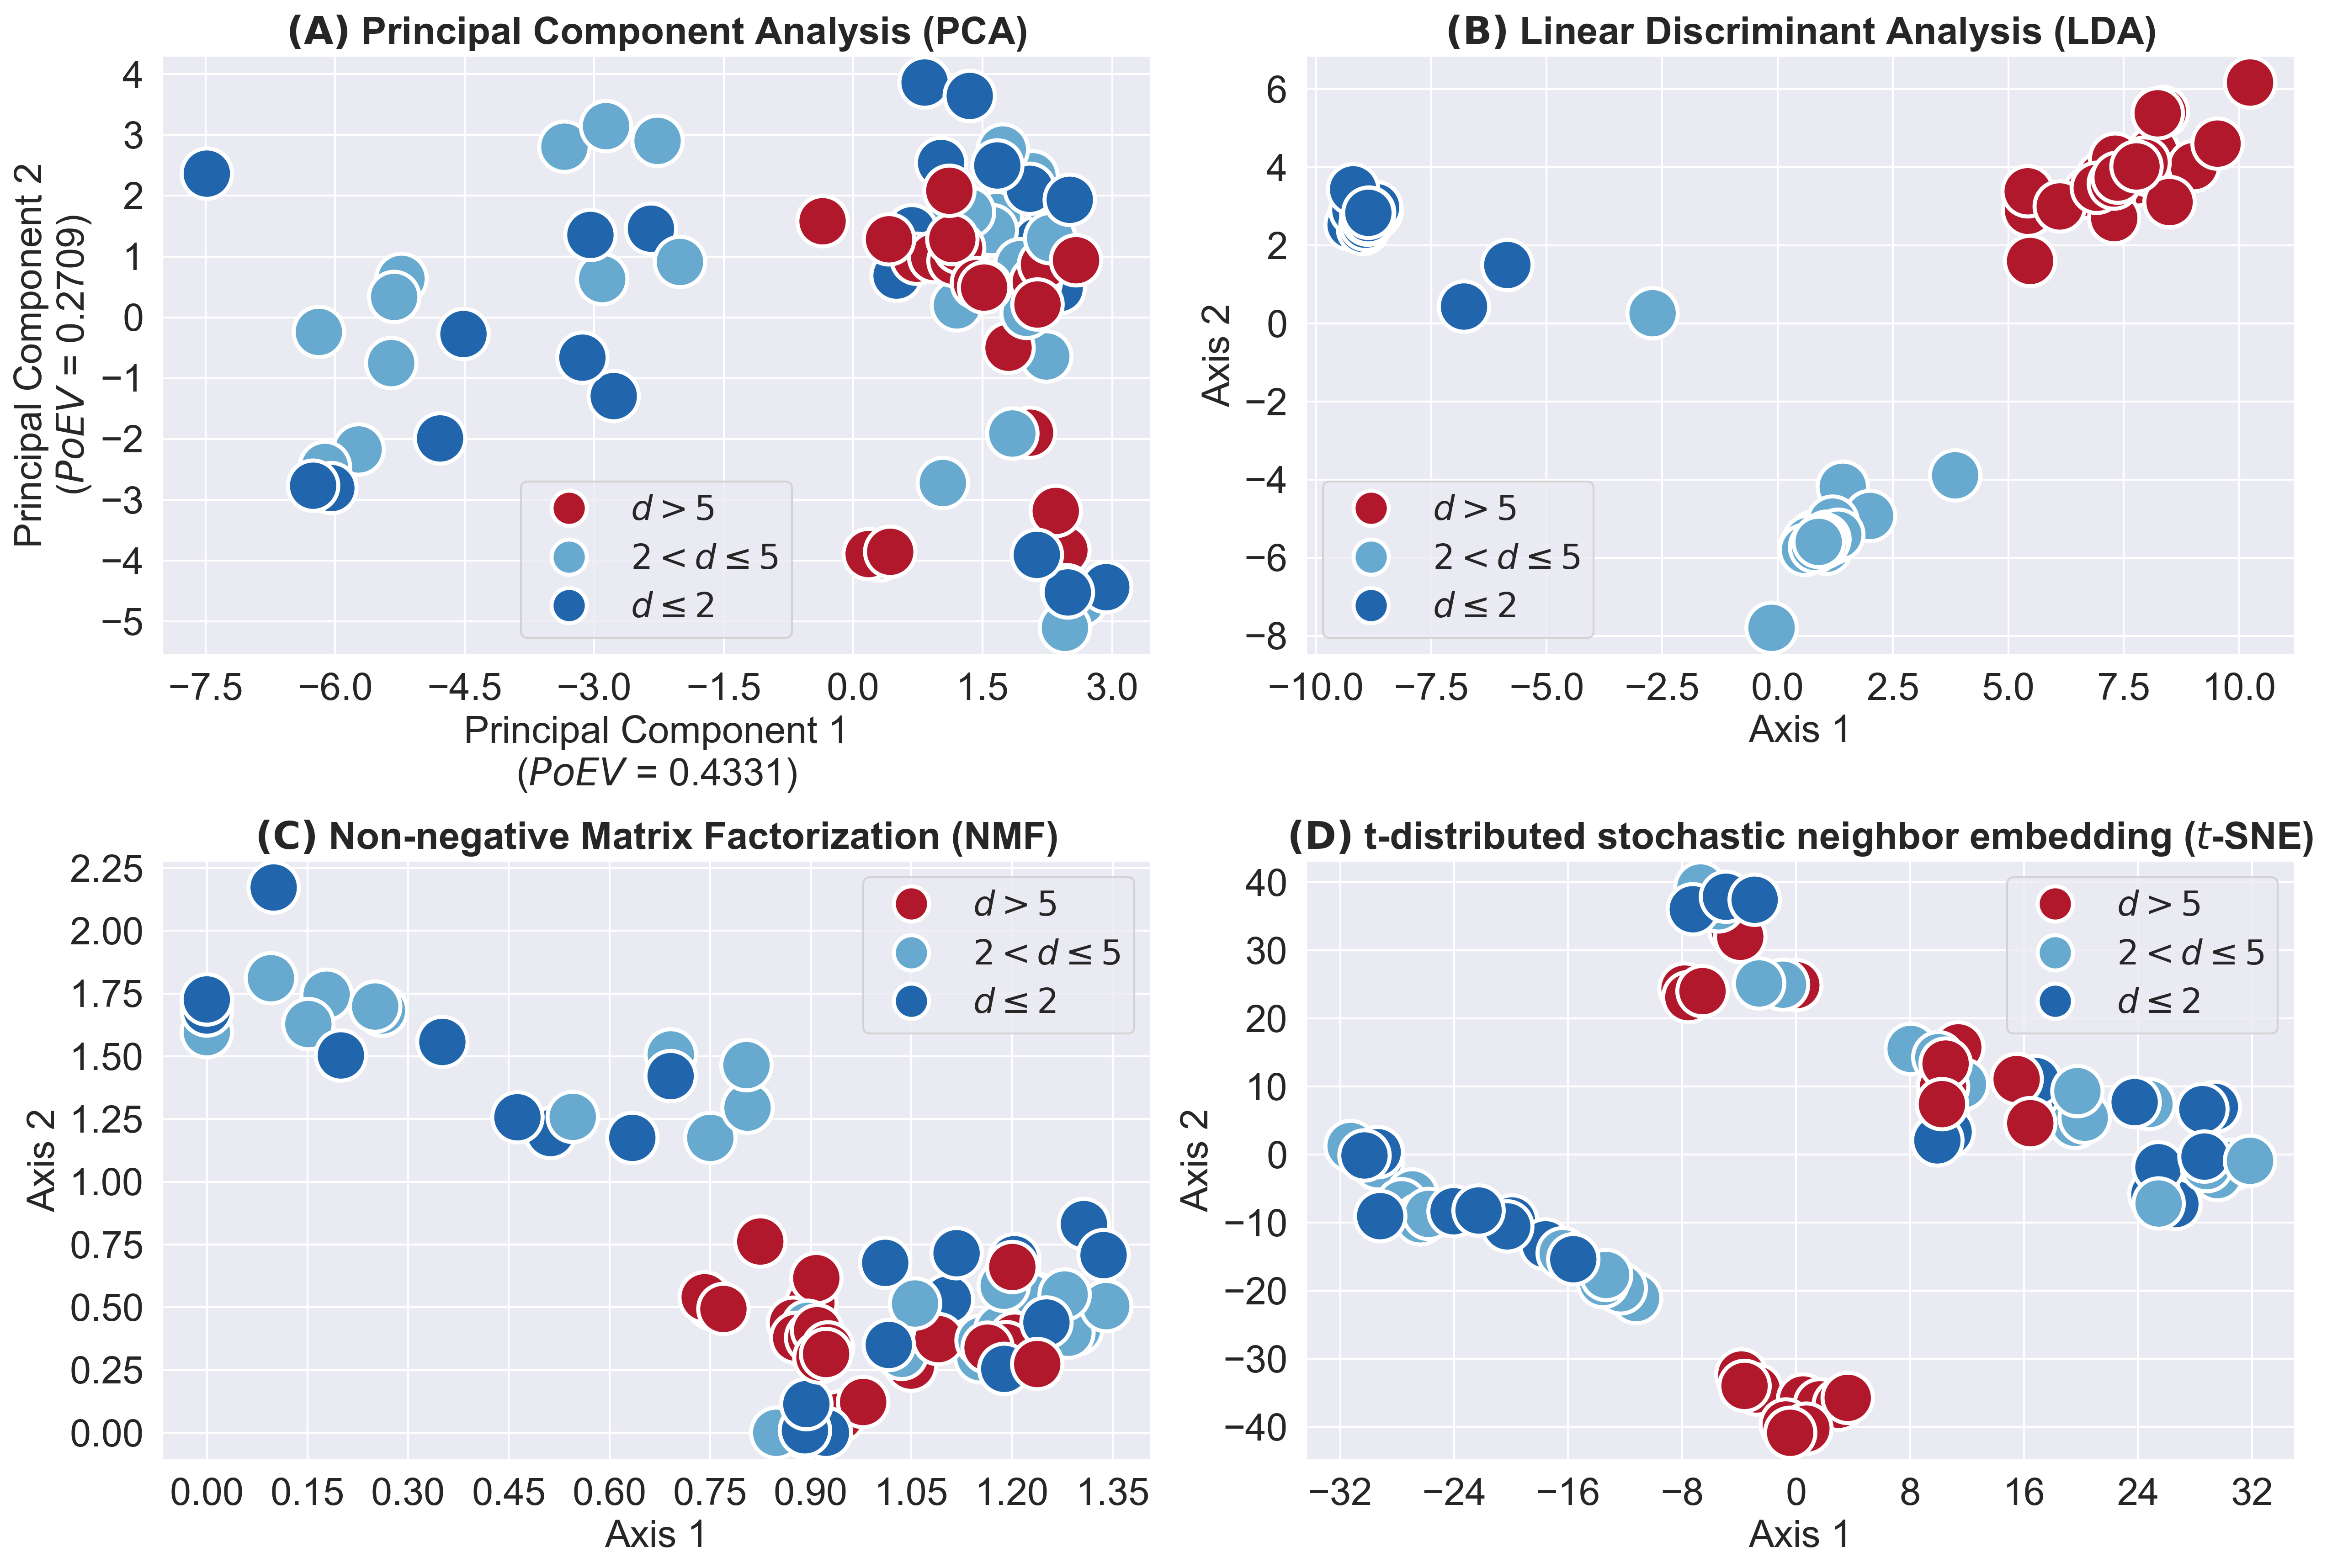

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1500, 1300)


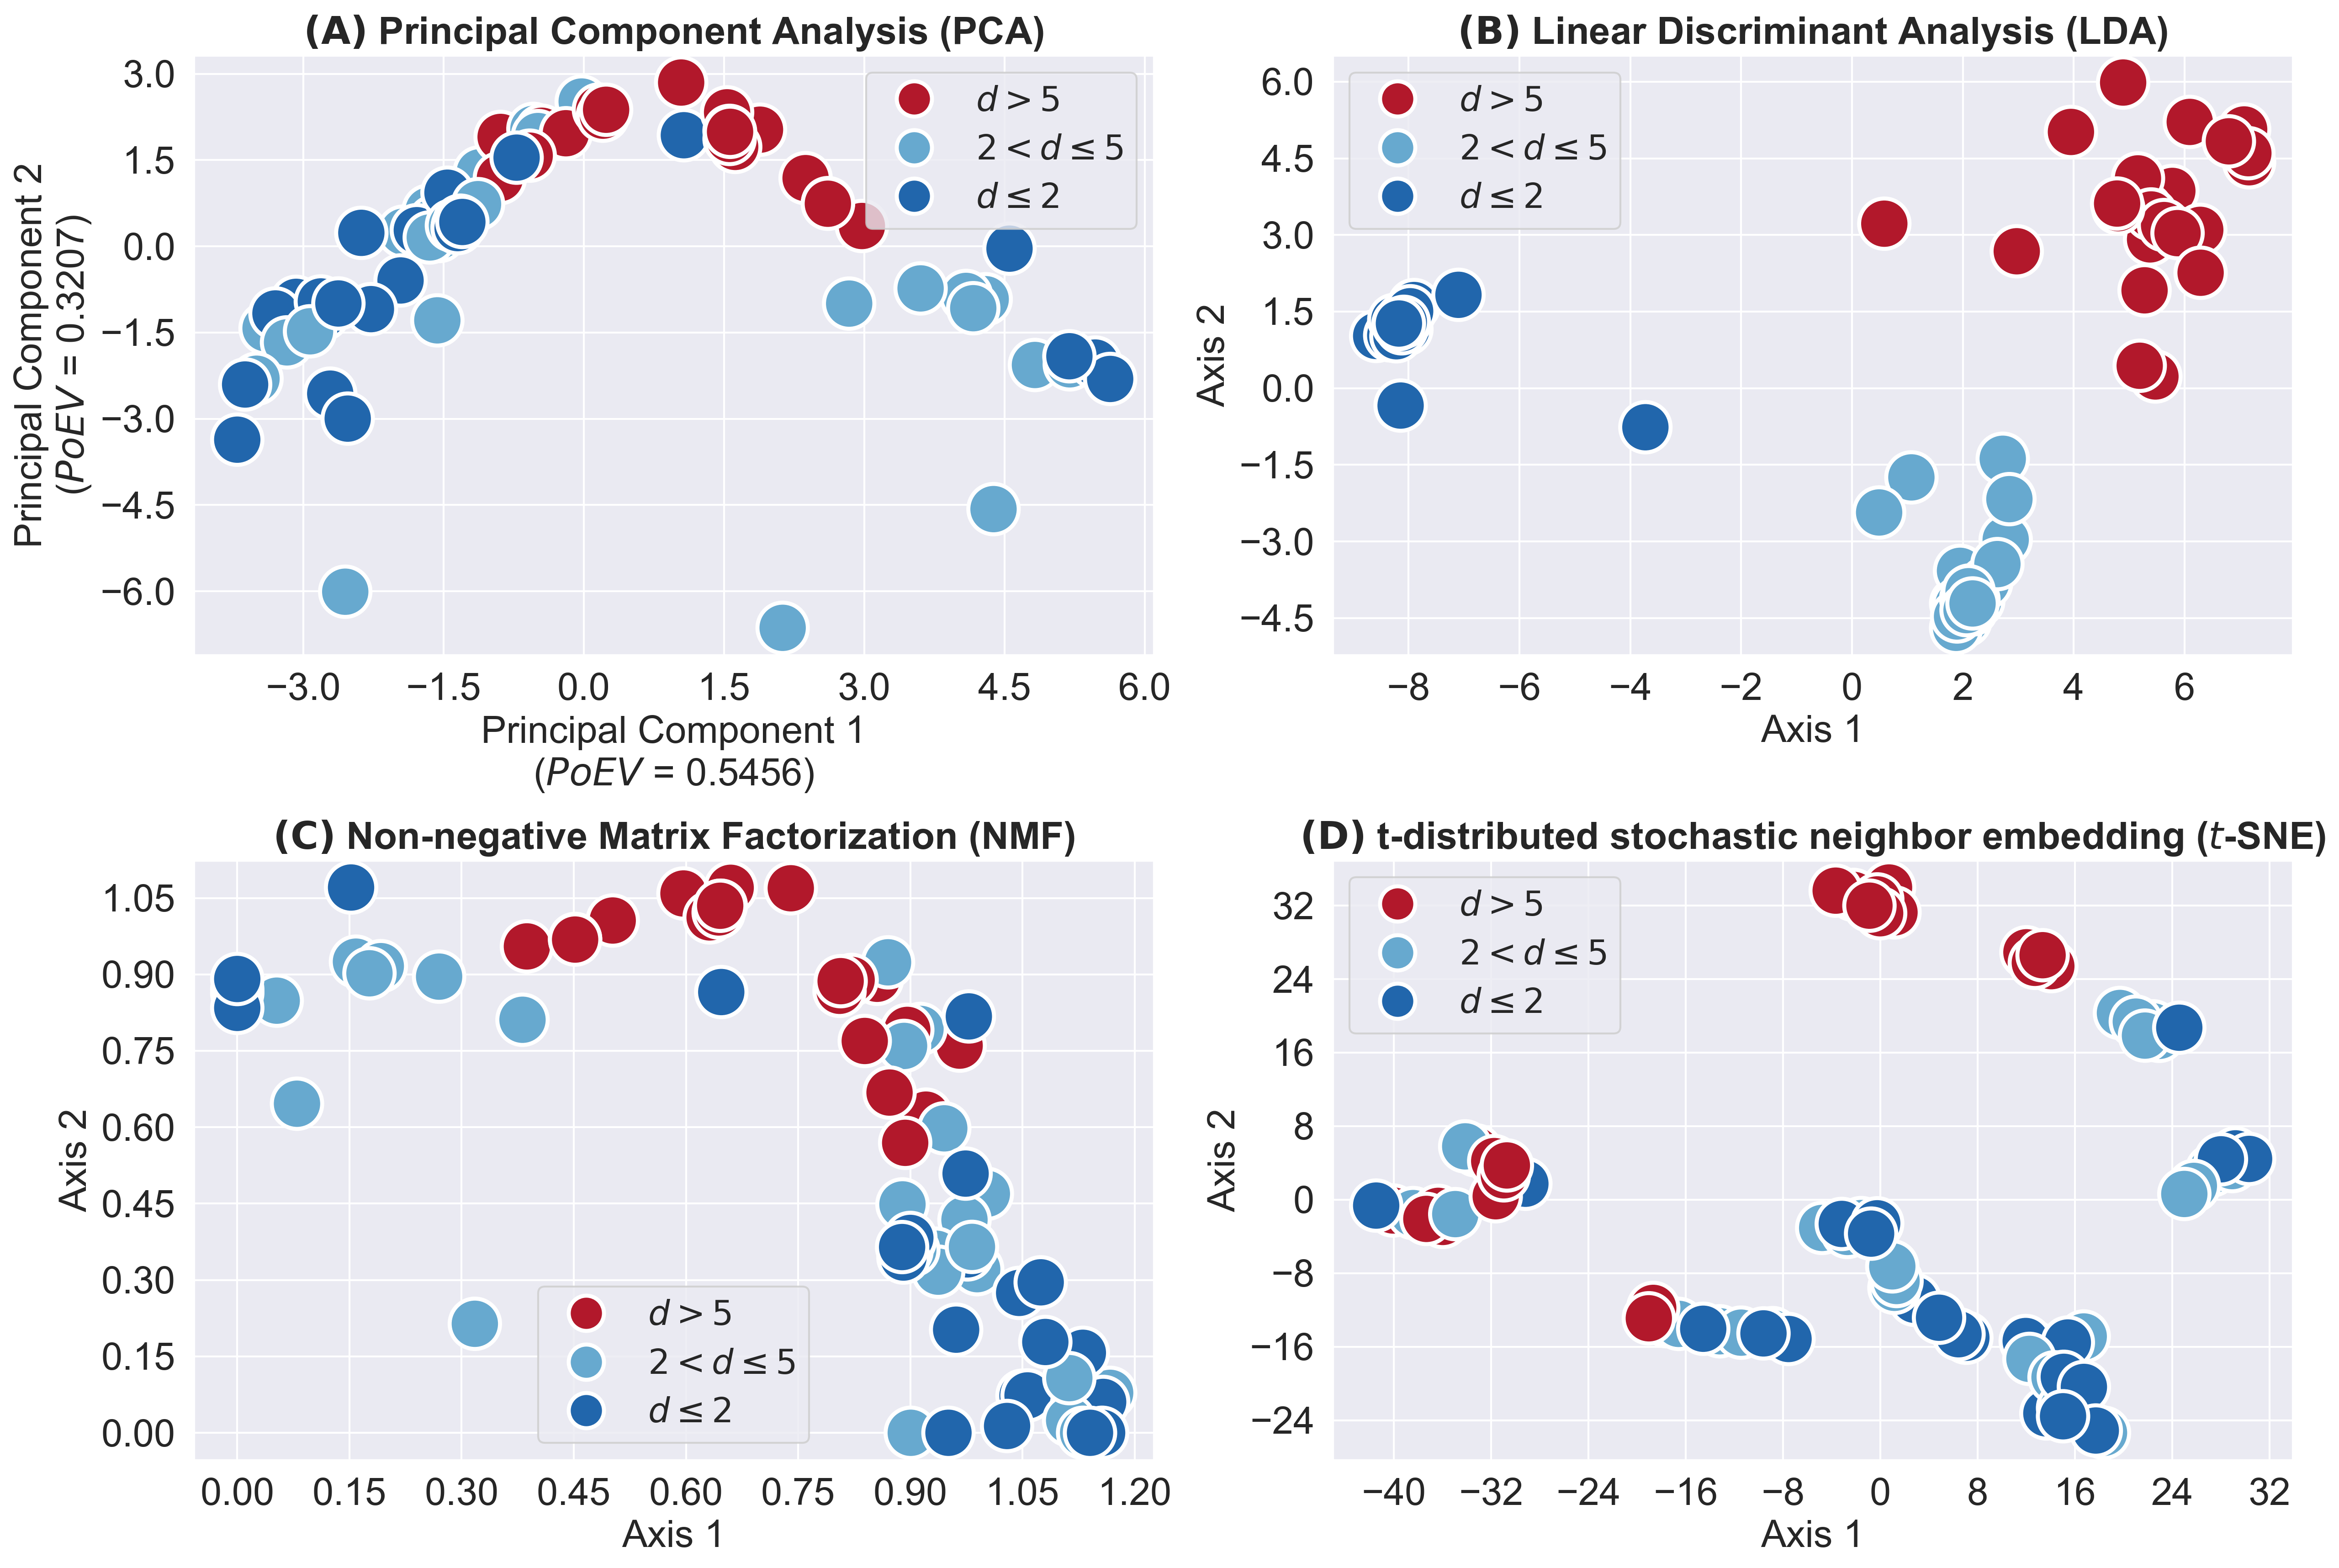

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: (1300, 900)


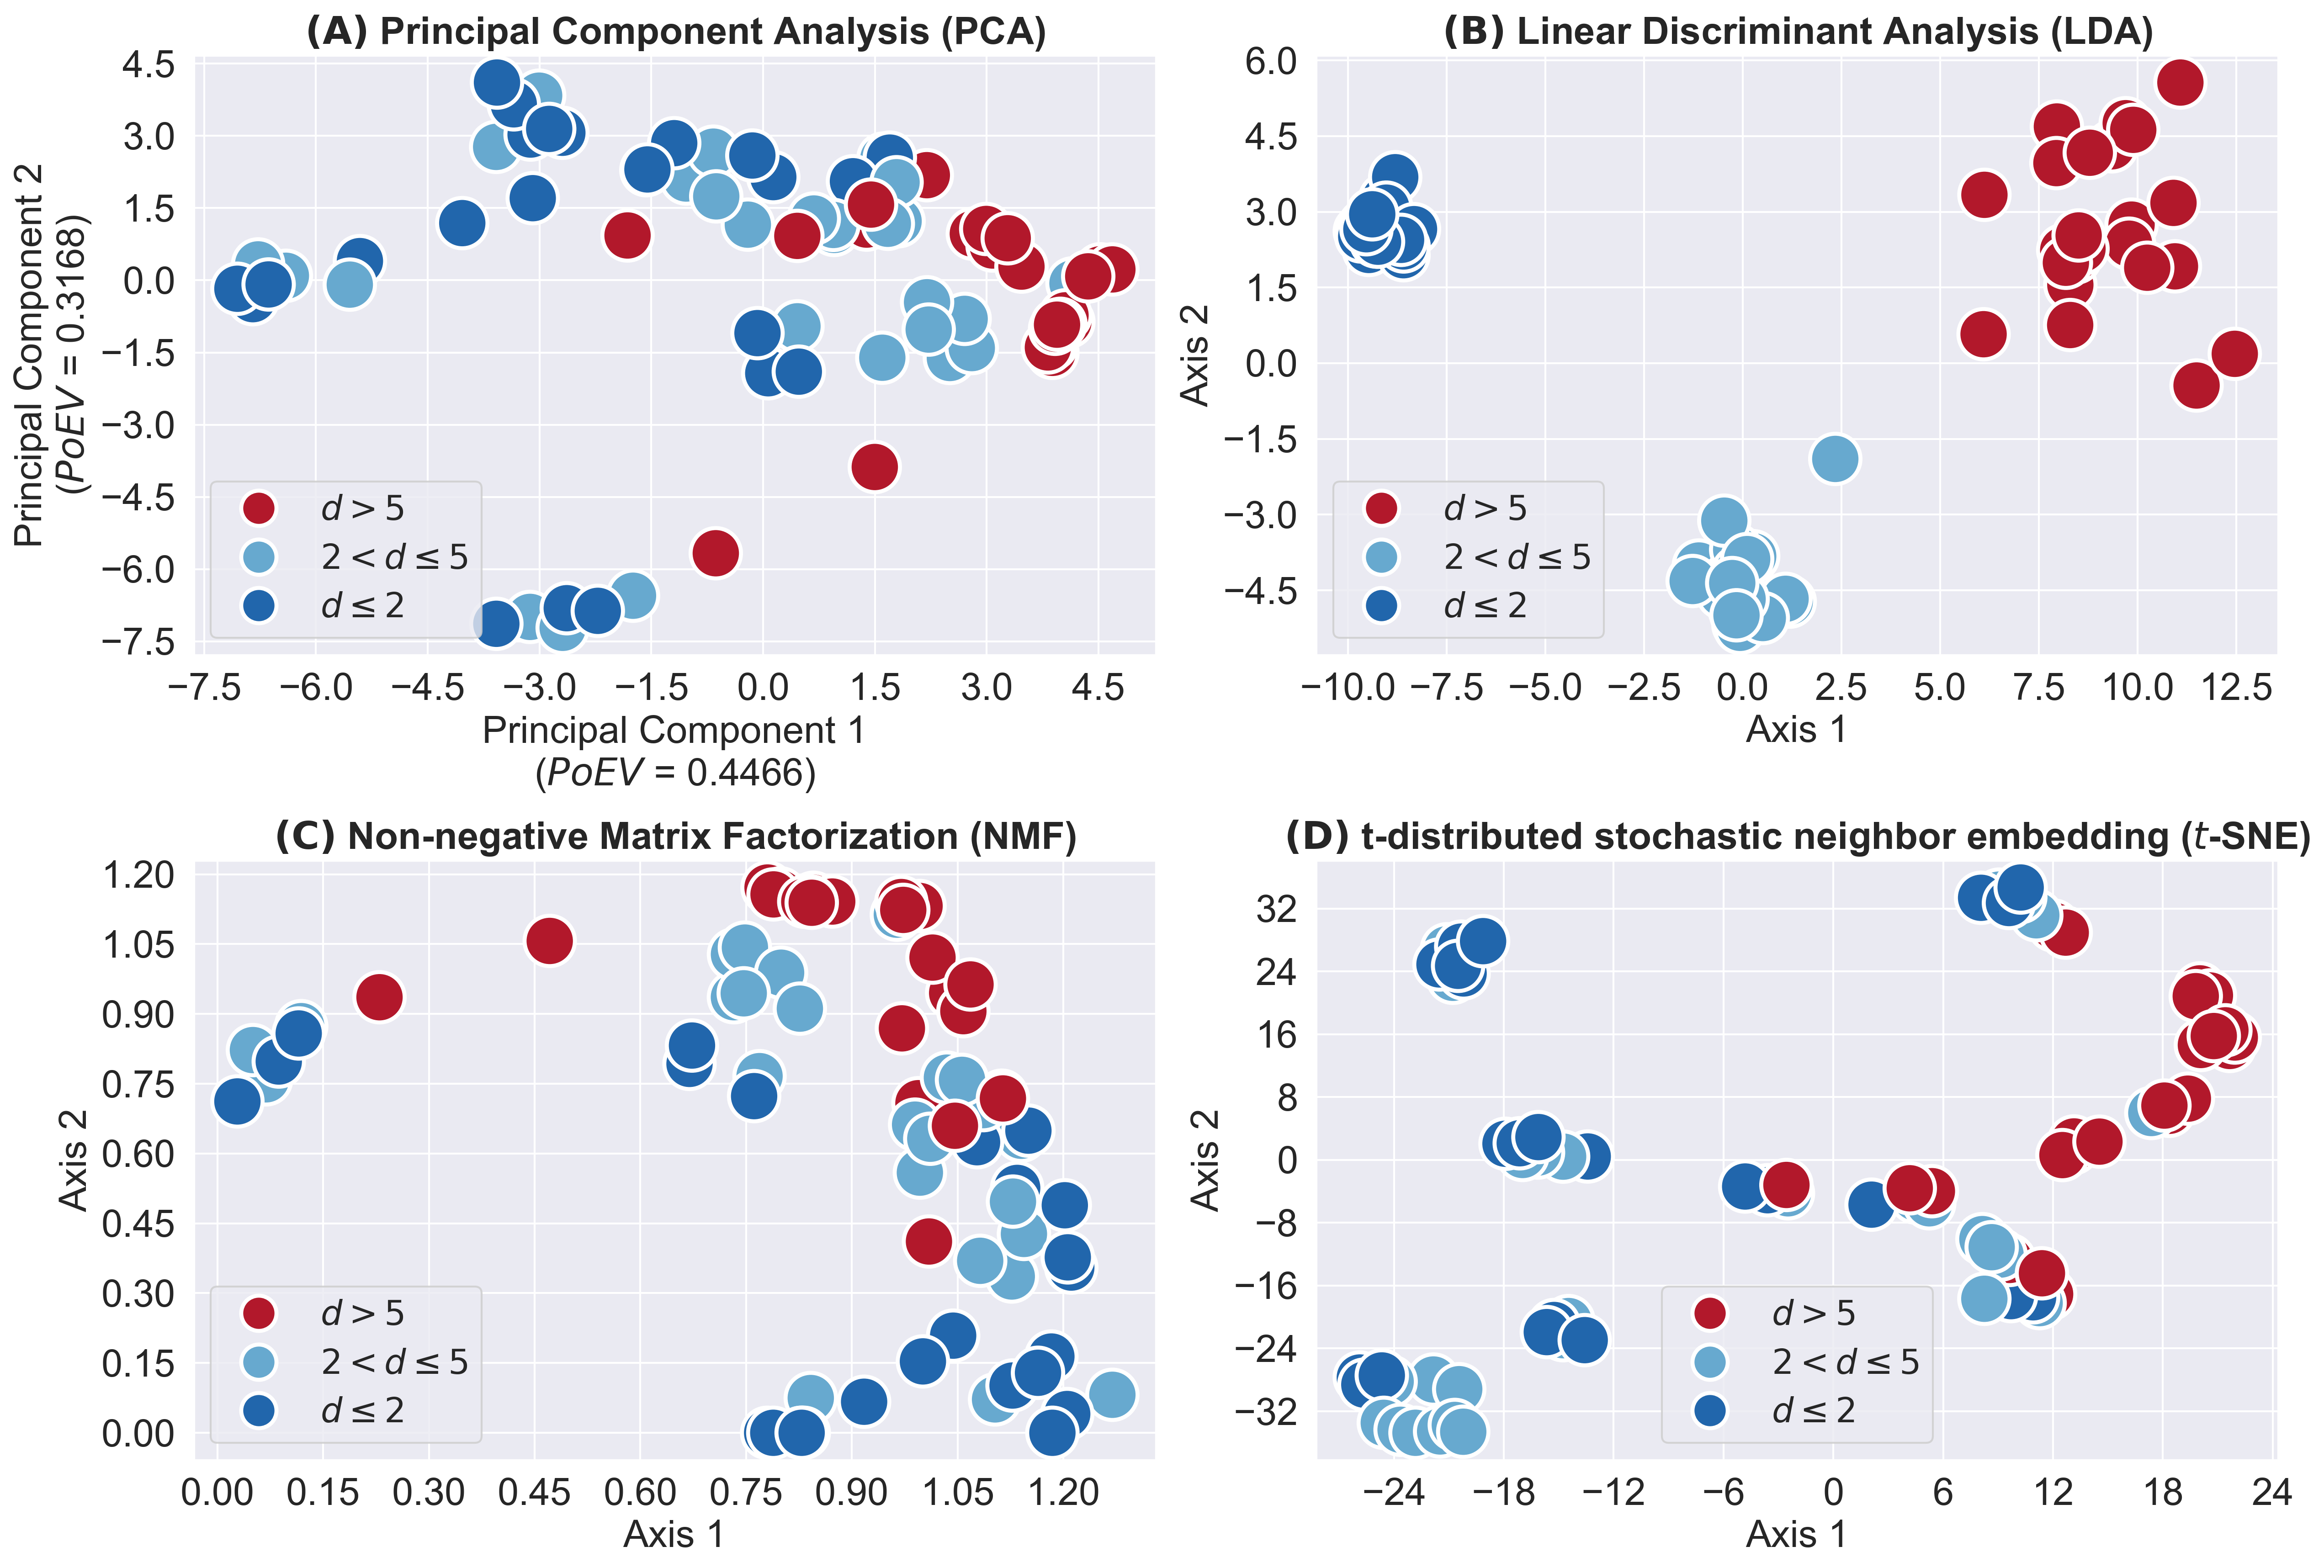

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
print(f'-' * 224)

for wn_range in wn_ranges:
    print(f'WAVENUMBER RANGE: {wn_range}')

    data = data_ranges[wn_range]

    dimred = DimensionalityReduction(data=data, hue=hue)

    dimred.get_pca(n_components=2, random_state=42)
    dimred.get_lda(target=target, n_components=2)
    dimred.get_nmf(n_components=2, random_state=42)
    dimred.get_tsne(n_components=2, perplexity=4, random_state=42)

    dimred.get_combined_visualization(
        figsize=figsize,
        palette=type_color_dict,
        markersize=markersize,
        fontsize=fontsize,
        path_to_save=f'{path_to_save}/dimred_{wn_range[0]}_{wn_range[1]}_4_subplots.svg'
    )

    print(f'-' * 224)